In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [19]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'r') as f:
    df = pd.read_csv(file_save, index_col=0)

In [20]:
df

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.296000,1861.3,71.3,245.0,66.1,0.0,0.0,0.000000,1883.296000,-21.996000
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.400000,1772.4,50.5,185.8,104.1,0.0,0.0,0.000000,1914.400000,-142.000000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.880000,1894.3,59.3,220.3,87.5,0.0,0.0,0.000000,1893.880000,0.420000
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.296000,1822.6,71.5,227.7,70.2,0.0,0.0,0.000000,1883.296000,-60.696000
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.040000,1891.5,61.8,217.2,82.5,0.0,0.0,0.000000,1896.040000,-4.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12,71.212222,11.544444,2.983333,56.666667,39.892222,0.162113,1658.824000,1765.3,37.0,175.4,195.8,0.0,0.0,0.000000,1658.824000,106.476000
2023-11-13,70.830000,11.471111,2.968889,56.373333,39.606667,0.161953,1652.152000,1853.7,51.2,143.3,216.6,2220.0,254.0,211.548872,1863.700872,-10.000872
2023-11-14,71.056667,11.332222,2.987778,56.717778,39.991111,0.159481,1660.048000,1715.3,36.2,154.0,211.0,1500.0,281.0,252.179722,1912.227722,-196.927722
2023-11-15,70.258750,11.072500,2.961250,56.208750,39.525000,0.157596,1648.423000,1654.8,45.5,135.1,186.2,3660.0,396.0,326.170970,1974.593970,-319.793970


In [105]:
# clean-up
df1 = df.copy(deep=True)
columns_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique', 'MG%', 'BMR', 'Lipides', 'Glucides', 'Proteines', 'exo_duree', 'exo_cals_bruts', 'Depense_cal_totale', 'cal_deficit']
df1.drop(columns=columns_to_drop, inplace=True)

In [106]:
df1

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-09,107.250000,37.190000,1861.3,0.000000
2020-08-11,104.650000,33.150000,1772.4,0.000000
2020-08-12,104.350000,33.800000,1894.3,0.000000
2020-08-13,104.400000,34.340000,1822.6,0.000000
2020-08-14,104.500000,33.850000,1891.5,0.000000
...,...,...,...,...
2023-11-12,71.212222,11.544444,1765.3,0.000000
2023-11-13,70.830000,11.471111,1853.7,211.548872
2023-11-14,71.056667,11.332222,1715.3,252.179722
2023-11-15,70.258750,11.072500,1654.8,326.170970


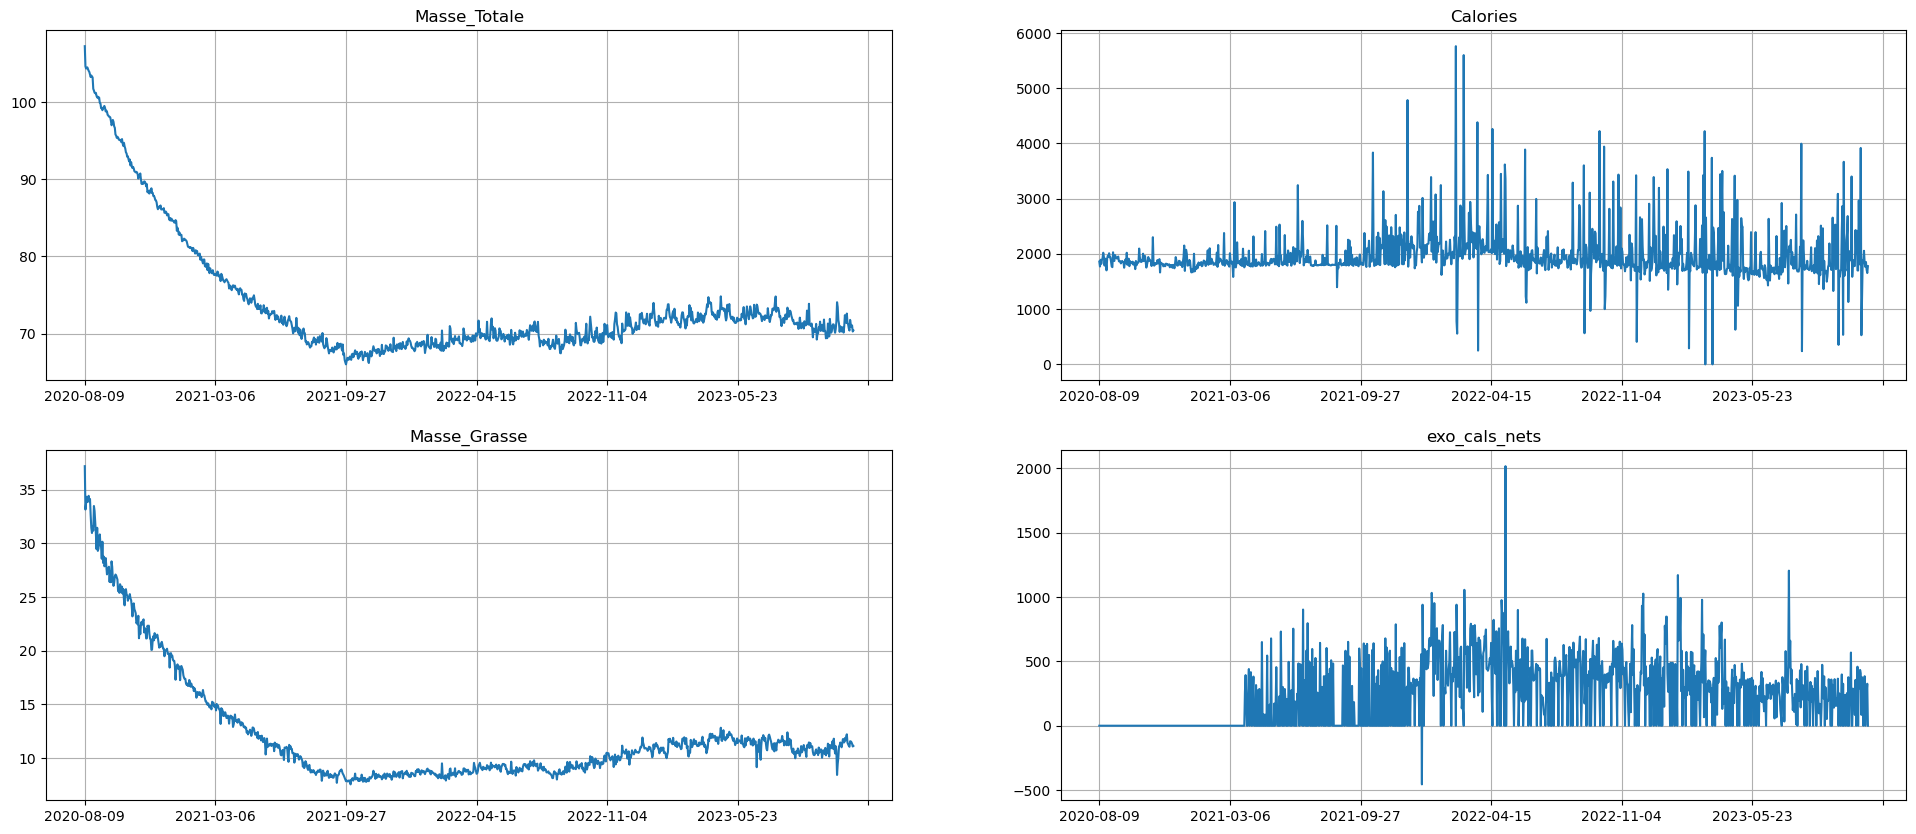

In [107]:
# Visu

fig, axs = plt.subplots(2,2,figsize=(24,10))

for i,name in enumerate(df1.columns):
    r = i%2
    c = i//2
    axs[r,c].set_title(name)
    df1[name].plot(ax=axs[r,c])
    axs[r,c].grid(True)

In [108]:
# need to check that datapoints follow by one day
# and deal with holes

In [109]:
# create dataset.
# targets are next day's Masse_Totale and Masse_Grasse values
# no averaging

df1 = pd.concat([df1.shift(1), df1['Masse_Totale'], df['Masse_Grasse']], axis=1)
df1.columns = ['MT', 'MG', 'Cals', 'Exos', 'MT+1', 'MG+1']
df1.dropna(inplace=True)

In [110]:
df1

,MT,MG,Cals,Exos,MT+1,MG+1
2020-08-11,107.250000,37.190000,1861.3,0.000000,104.650000,33.150000
2020-08-12,104.650000,33.150000,1772.4,0.000000,104.350000,33.800000
2020-08-13,104.350000,33.800000,1894.3,0.000000,104.400000,34.340000
2020-08-14,104.400000,34.340000,1822.6,0.000000,104.500000,33.850000
2020-08-15,104.500000,33.850000,1891.5,0.000000,104.250000,34.280000
...,...,...,...,...,...,...
2023-11-12,71.765000,11.561250,1837.8,384.759938,71.212222,11.544444
2023-11-13,71.212222,11.544444,1765.3,0.000000,70.830000,11.471111
2023-11-14,70.830000,11.471111,1853.7,211.548872,71.056667,11.332222
2023-11-15,71.056667,11.332222,1715.3,252.179722,70.258750,11.072500


In [314]:
df2 = df1.copy(deep=True)

In [315]:
from datetime import datetime
df2.index = pd.to_datetime(df2.index)
df2 = df2[df2.index >= datetime(2022,1,1)]

In [316]:
length_average = 45

In [317]:
df2 = df2.rolling(window=length_average).mean()
df2.dropna(inplace=True)
df2

,MT,MG,Cals,Exos,MT+1,MG+1
2022-02-14,68.567910,8.610790,2178.797778,517.619570,68.554195,8.606428
2022-02-15,68.554195,8.606428,2155.191111,505.570576,68.534381,8.602665
2022-02-16,68.534381,8.602665,2152.257778,502.646544,68.512612,8.602087
2022-02-17,68.512612,8.602087,2153.846667,512.727092,68.500334,8.603354
2022-02-18,68.500334,8.603354,2151.942222,507.966792,68.480482,8.607476
...,...,...,...,...,...,...
2023-11-12,70.979171,10.965644,1982.344444,203.604237,70.990498,10.982604
2023-11-13,70.990498,10.982604,1983.255556,200.191867,70.983748,11.014823
2023-11-14,70.983748,11.014823,1985.497778,200.211803,70.996841,11.035484
2023-11-15,70.996841,11.035484,1971.075556,202.279535,70.996080,11.044006


In [318]:
df2

,MT,MG,Cals,Exos,MT+1,MG+1
2022-02-14,68.567910,8.610790,2178.797778,517.619570,68.554195,8.606428
2022-02-15,68.554195,8.606428,2155.191111,505.570576,68.534381,8.602665
2022-02-16,68.534381,8.602665,2152.257778,502.646544,68.512612,8.602087
2022-02-17,68.512612,8.602087,2153.846667,512.727092,68.500334,8.603354
2022-02-18,68.500334,8.603354,2151.942222,507.966792,68.480482,8.607476
...,...,...,...,...,...,...
2023-11-12,70.979171,10.965644,1982.344444,203.604237,70.990498,10.982604
2023-11-13,70.990498,10.982604,1983.255556,200.191867,70.983748,11.014823
2023-11-14,70.983748,11.014823,1985.497778,200.211803,70.996841,11.035484
2023-11-15,70.996841,11.035484,1971.075556,202.279535,70.996080,11.044006


In [319]:
X = df2[['MT', 'MG', 'Cals', 'Exos']]
y_mt = df2['MT+1']
y_mg = df2['MG+1']

In [320]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_mt_train, y_mt_test = train_test_split(X, y_mt, test_size=0.2, random_state=42)

X_train = X
y_mt_train = y_mt

In [321]:
# Gaussian process

kernel = RBF(length_scale=7, length_scale_bounds=(1e-1,1e2)) + WhiteKernel(noise_level=2.0, noise_level_bounds=(1e-3, 1e2))  # length scal ~ one week; noise ~ 2 kg

gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.0, random_state=42, normalize_y=True, n_restarts_optimizer=9 )

In [322]:
gpr.fit(X_train, y_mt_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [323]:
mean_prediction, std_prediction = gpr.predict(X_train, return_std=True)

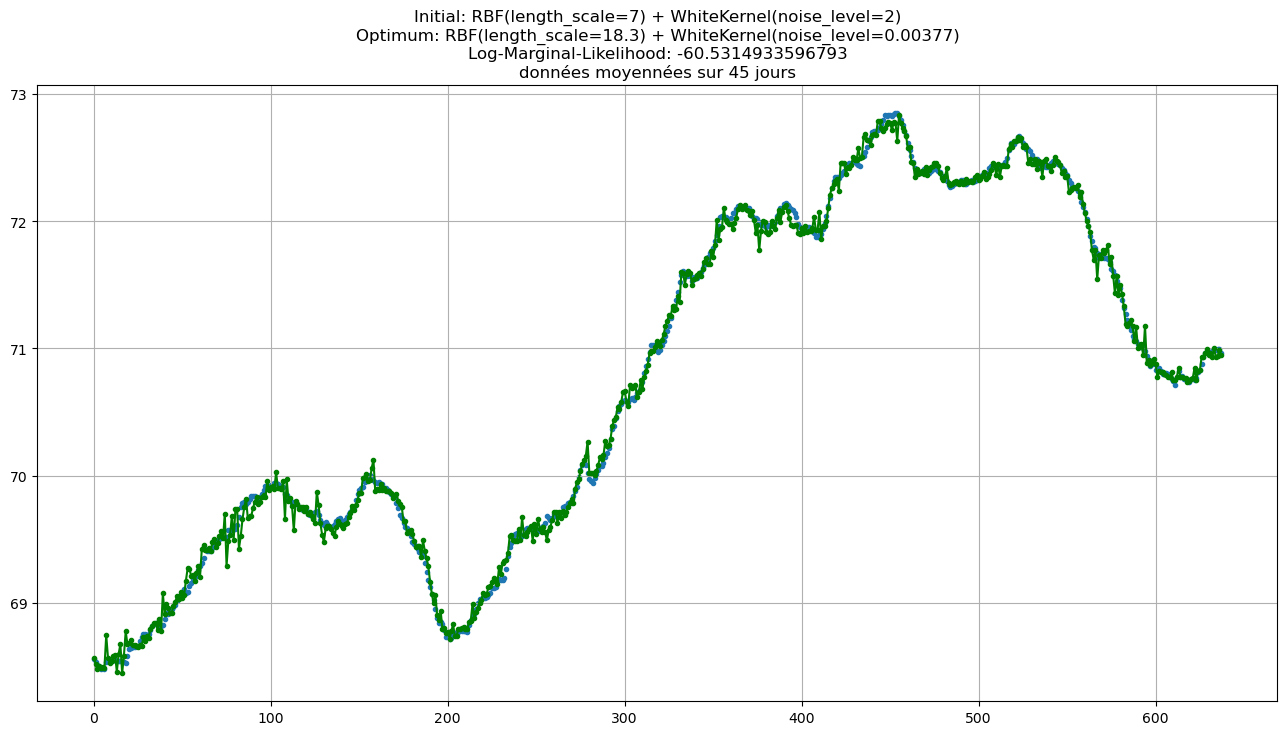

In [325]:
fig, ax = plt.subplots(figsize=(16,8))

abscisses = np.arange(X_train.shape[0])
ax.scatter(abscisses, y_mt_train, marker='.', label="Observations")
ax.plot(abscisses, mean_prediction, marker='.', label="Mean prediction", color='green')
ax.set_title(f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" \
            f"données moyennées sur {length_average} jours"
    )
ax.grid(True)
# plt.fill_between(
#     X.ravel(),
#     mean_prediction - 1.96 * std_prediction,
#     mean_prediction + 1.96 * std_prediction,
#     alpha=0.5,
#     label=r"95% confidence interval",
# )
# plt.legend()
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# _ = plt.title("Gaussian process regression on noise-free dataset")
plt.show()